# Problem 4.11

***Fundamentals of Solar Cells and Photovoltaic Systems Engineering***

**Solutions Manual - Chapter 4**

***Problem 4.11***



___Using the same solar cell parameters of Problem S4.4 (with series resistance Rs=1mΩ and parallel resistance Rp=500 Ω), <br>
(a)	generate one I-V curve using a high number of datapoints (for example 500) and then extract the one-diode model parameters from it using the 5-point method coded in the python notebook for this problem. Do the Rs and Rp extracted fit the actual values? <br>
(b)	Now decrease the number of datapoints in the I-V curve down to 50 and see how the extracted parameters vary.  Why does that happen? <br>
(c)	Finally, increase the noise in the data and see how the extracted parameters vary. Explain why this happens and propose a way to mitigate this effect.___

First, we import the Python modules used and define the Boltzman constant

In [1]:
import numpy as np
import matplotlib.pyplot as plt

kB = 8.617333e-5

We define the variables for the I-V curve data

In [2]:
# These are values in the usual range for a typical 16.6 x 16.6 cm2 Si solar cell
Isc = 10.0 # A
I0 = 2e-9 # A
Rs = 1e-3 # ohm
Rp = 500 # ohm
n = 1.2

temperature = 25  #ºC
cell_area = 16.6*16.6 # cm2

#### Function to **generate I-V curves** using as input the parameters of the one-diode model

In [3]:
# Input data: 
# · single-diode model parameters
# · temperature
# · noise in the current, defined as a normal distribution with std dev of I*Inoise
# · number of datapoints to use
def model_IV(IL, I0, n, Rs, Rp, temperature, Inoise, data_size):
    # Thermal voltage
    kBT = kB*(temperature + 273.15)
    
    #I-V curve stored in a 2-column array: first column for voltages, second column for currents
    IVcurve = np.zeros((data_size,2))
    
    # First we calculate the I-V curve voltage range: from -0.1 V to Voc + 0.01 V
    # We want to have the I-V curve crossing the current and voltage axis to see the Isc and Voc
    
    # To determine the voltage range, we calculate first the Voc without Rs/Rp.
    Voc0 = n*kBT*np.log(IL/I0)
    
    #Create the voltage list
    #Voltage range used: -0.1 to Voc+0.01
    #A "Rs*IL" term is added to compensate for the voltage drop in the Rs
    IVcurve[:,0]= np.linspace(-0.1+Rs*IL, Voc0+0.01, data_size)
    
    #I-V curve without Rs effect
    IVcurve[:,1]= IL - I0*(np.exp(IVcurve[:,0]/(n*kBT))-1) - IVcurve[:,0]/Rp
    
    #Shift voltages to include Rs effect
    IVcurve[:,0] = IVcurve[:,0] - Rs*IVcurve[:,1]
    
    # Add noise to the current.
    # The noise component follows a normal distribution with std dev of I*Inoise
    IVnoise = np.random.default_rng().normal(0, np.absolute(IVcurve[:,1])*Inoise)
    IVcurve[:,1]+=IVnoise
    
   
    return IVcurve

#### Function to extract the I-V curve parameters
The algorithm is from: <br>
* Cotfas, D.T., Cotfas, P.A., Kaplanis, S., 2013. Methods to determine the dc parameters of solar cells: A critical review. Renew. Sustain. Energy Rev. 28, 588–596. https://doi.org/10.1016/j.rser.2013.08.017

Note that this function does not assume that the I-V curve is in the first quadrant. 

Another two functions are used to calculate the Isc and Voc and detect the quadrant. Then, the function calculating Pmax moves the I-V curve to this quadrant, if it is not there yet. 

In [4]:
# Input data:
# · experimental I-V curve
# · temperature
# · number of points around Isc to calculate the I-V slope
# · number of points around Voc to calculate the I-V slope

def get_IV_params(rawIV, temperature):
    # Thermal voltage
    kBT = 8.617333e-5*(temperature + 273.15)
    
    ## 1) Prepare the I-V curve to be in 1st quadrant and 
    ##    with increasing values of voltage
    # Move I-V curve to first quadrant if it is not there yet
    # Sort data and move to first quadrant
    IV_1stq = rawIV.copy()
    Isc = get_Isc(IV_1stq)
    if Isc<0:
        Isc*=-1
        IV_1stq[:,1]*=-1
    
    Voc = get_Voc(IV_1stq)
    if Voc<0:
        Voc*=-1
        IV_1stq[:,0]*=-1    

    # Sort I-V curve data to have increasing values of voltage
    IV_1stq=IV_1stq[IV_1stq[:,0].argsort()]     
    ##
    
    ## 2) Algorithm for the 5-point method
    ##
    
    # Calculate Rp as the inverse of the slope at V=0
    # The function "getSlope_atIsc" returns the slope and the linear function to be plotted later
    slopeIsc, slopeFitIsc = getSlope_atIsc(IV_1stq)
    Rp = -1/slopeIsc
   
     # Calculate the maximum power and V, I at maximum power point
    Pm, Vm, Im = get_Pmax(rawIV)
    
    # Calculate the slope at Voc as intermediate parameter
    # The function "getSlope_atVoc" returns the slope and the linear function to be plotted later
    slopeVoc, slopeFitVoc = getSlope_atVoc(IV_1stq)
    
    # Intermediate calculations in the 5-point algorithm
    Rs0 = -1/slopeVoc
    
    A = Vm + Rs0*Im-Voc
    B = np.log(Isc-Vm/Rp-Im)-np.log(Isc-Voc/Rp)
    C = Im/(Isc-Voc/Rp)
    n = A/(kBT*(B+C))    
    
    I0 = (Isc-Voc/Rp)*np.exp(-Voc/(n*kBT))
  
    Rs = Rs0 -n*(kBT/I0)*np.exp(-Voc/(n*kBT))
   
    IL = Isc*(1+Rs/Rp) + I0*(np.exp(Isc*Rs/(n*kBT))-1)


    return IL, I0, n, Rs, Rp, slopeFitIsc, slopeFitVoc

And ancillary functions to serve "get_IV_params"

In [5]:
# Obtains Isc by linear interpolation around V=0
def get_Isc(IVdata):
    """Returns the Isc of the input raw I-V curve"""

   # Sort data
    IV_sorted = IVdata.copy()
    IV_sorted=IVdata[IVdata[:,0].argsort()]   # Sort by voltages
    
    Isc = np.interp(0,IV_sorted[:,0],IV_sorted[:,1])
    
    return Isc

# Obtains Voc by linear interpolation around I=0
def get_Voc(IVdata):
    """Returns the Voc of the input raw I-V curve"""

   # Sort data
    IV_sorted = IVdata.copy()
    IV_sorted=IVdata[IVdata[:,1].argsort()]   # Sort by currents
    
    Voc = np.interp(0, IV_sorted[:,1],IV_sorted[:,0])
    
    return Voc

# Obtains the Pmax, and also the Vm and Im
def get_Pmax(IVdata):
  
   # Sort data and move to 1st quadrant
    IV_sorted = IVdata.copy()
 
    Isc = get_Isc(IV_sorted)
    if Isc<0:
        Isc*=-1
        IV_sorted[:,1]*=-1
    
    Voc = get_Voc(IV_sorted)
    if Voc<0:
        Voc*=-1
        IV_sorted[:,0]*=-1       
 
    IV_sorted=IV_sorted[IV_sorted[:,0].argsort()]   
   
 
    PV = IV_sorted.copy()
    PV[:,1] = IV_sorted[:,0]*IV_sorted[:,1]
    
    Pm = np.amax(PV[:,1])
    maxPosition = np.argmax(PV[:,1])
    Vm = PV[maxPosition,0]
    Im = IV_sorted[maxPosition,1]

    return Pm, Vm, Im

# Determines the slope of the I-V curve around Voc
# I-V curve is assumed to be in 1st quadrant
def getSlope_atVoc(data):
  
    # Find the first negative current point
    # Determine the range for the fit according to nPnts
    rI = np.where(data[:,1] <= 0)
    rangeI = np.asarray(rI)  
    rangeI = rangeI.flatten()   
    
    indexEnd = rangeI[0] + 2
    if indexEnd > len(data[:,0])-1:
        indexEnd = len(data[:,0])-1
    indexStart = rangeI[0] - 2
    if indexStart < 0:
        indexStart=0
    
    # Fit to a polynomial of degree 1
    polyCoeffs = np.polyfit(data[indexStart:indexEnd+1,0],data[indexStart:indexEnd+1,1],1)

    slope = polyCoeffs[0]
   
    # Create array with fit line
    slopeFitVoc = np.zeros((50,2))
    slopeFitVoc[:,0]=np.linspace(data[indexStart,0],data[indexEnd,0],50)
    slopeFitVoc[:,1] = np.polyval(polyCoeffs, slopeFitVoc[:,0])

    return slope, slopeFitVoc

# Returns the slope of I-V curve at Isc using
# a linear fit for a V range of +-Vrange     
def getSlope_atIsc(data):
    
    # Get data indexes in the Vrange
    rV = np.where(data[:,0] <= 0)
    rangeV = np.asarray(rV)  
    rangeV = rangeV.flatten()   

    indexStart = rangeV[-1] -5   
    if indexStart < 0:
        indexStart=0
    indexEnd = rangeV[-1] + 5
    if indexEnd > len(data[:,0])-1:
        indexEnd = len(data[:,0])-1
 
    # Fit to a polynomial of degree 1
    polyCoeffs = np.polyfit(data[indexStart:indexEnd+1,0],data[indexStart:indexEnd+1,1],1)
    #Take the slope from the linear fit
    slope = polyCoeffs[0]
 
    # Create array with fit line
    slopeFitIsc = np.zeros((50,2))
    slopeFitIsc[:,0]=np.linspace(data[indexStart,0],data[indexEnd,0],50)
    slopeFitIsc[:,1] = np.polyval(polyCoeffs, slopeFitIsc[:,0])


    return slope, slopeFitIsc


Now we can make I-V curves and test the parameter extraction method

Rp = 499.979
Rs = 9.170e-04
I0 = 2.41e-09
n = 1.210
IL = 10.000


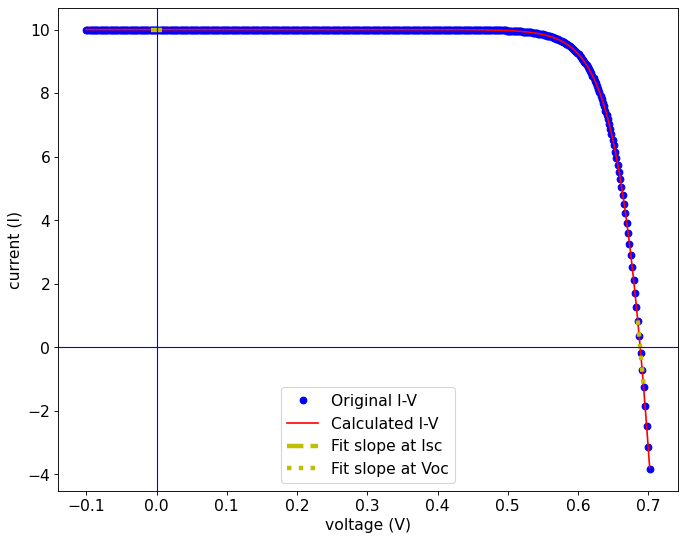

In [7]:
data_size = 500
I_noise = 0
IV_curve = model_IV(Isc, I0, n, Rs, Rp, temperature, I_noise, data_size)

IL_extr, I0_extr, n_extr, Rs_extr, Rp_extr, slopeFitIsc, slopeFitVoc = get_IV_params(IV_curve, temperature)

IV_curve_extracted = model_IV(IL_extr, I0_extr, n_extr, Rs_extr, Rp_extr, temperature, 0, 500)

# Print the results and errors
print("Rp = " + f"{Rp_extr:.3f}")
#print("Error Rp = " + f"{100*(Rp_extr-Rp)/Rp:.3f}" + " %")
print("Rs = " + f"{Rs_extr:.3e}")
#print("Error Rs = " + f"{100*(Rs_extr-Rs)/Rs:.3f}" + " %")
print("I0 = " + f"{I0_extr:.3}") 
#print("Error I0 = " + f"{100*(I0_extr-I0)/I0:.3f}" + " %")
print("n = " + f"{n_extr:.3f}")
#print("Error n = " + f"{100*(n_extr-n)/n:.3f}" + " %")
print("IL = " + f"{IL_extr:.3f}")
#print("Error Isc = " + f"{100*(Isc_extr-Isc)/Isc:.3f}" + " %")

# Plot the I-V curves
plt.figure(figsize=(10, 8),dpi=80)
plt.plot(IV_curve[:,0], IV_curve[:,1], 'bo', label="Original I-V")
plt.plot(IV_curve_extracted[:,0], IV_curve_extracted[:,1], color='r', label = "Calculated I-V")
plt.plot(slopeFitIsc[:,0],slopeFitIsc[:,1], '--', linewidth=4, color='y', label = "Fit slope at Isc")
plt.plot(slopeFitVoc[:,0],slopeFitVoc[:,1], ':', linewidth=4, color='y', label = "Fit slope at Voc")
#plt.ylim((-0.01, Isc*1.1))
plt. axvline(x=0,linewidth=1, color='b')
plt. axhline(y=0,linewidth=1, color='b')
plt.xlabel('voltage (V)', size=14)
plt.ylabel('current (I)', size=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

As you can see, the I-V curve parameters extraction method is accurate provided that the slopes at Voc and Isc are well defined. <br>


Rp = 499.959
Rs = 1.789e-03
I0 = 1.89e-10
n = 1.084
IL = 10.000


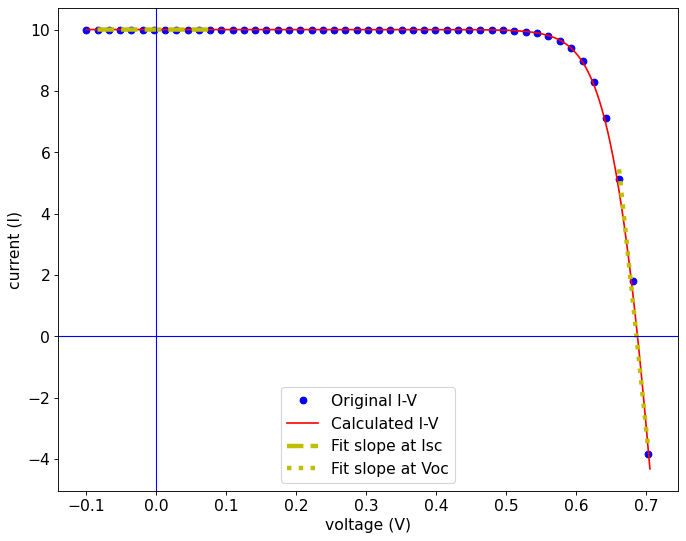

In [10]:
data_size = 50
I_noise = 0
IV_curve = model_IV(Isc, I0, n, Rs, Rp, temperature, I_noise, data_size)

IL_extr, I0_extr, n_extr, Rs_extr, Rp_extr, slopeFitIsc, slopeFitVoc = get_IV_params(IV_curve, temperature)

IV_curve_extracted = model_IV(IL_extr, I0_extr, n_extr, Rs_extr, Rp_extr, temperature, 0, 500)

# Print the results and errors
print("Rp = " + f"{Rp_extr:.3f}")
#print("Error Rp = " + f"{100*(Rp_extr-Rp)/Rp:.3f}" + " %")
print("Rs = " + f"{Rs_extr:.3e}")
#print("Error Rs = " + f"{100*(Rs_extr-Rs)/Rs:.3f}" + " %")
print("I0 = " + f"{I0_extr:.3}") 
#print("Error I0 = " + f"{100*(I0_extr-I0)/I0:.3f}" + " %")
print("n = " + f"{n_extr:.3f}")
#print("Error n = " + f"{100*(n_extr-n)/n:.3f}" + " %")
print("IL = " + f"{IL_extr:.3f}")
#print("Error Isc = " + f"{100*(Isc_extr-Isc)/Isc:.3f}" + " %")

# Plot the I-V curves
plt.figure(figsize=(10, 8),dpi=80)
plt.plot(IV_curve[:,0], IV_curve[:,1], 'bo', label="Original I-V")
plt.plot(IV_curve_extracted[:,0], IV_curve_extracted[:,1], color='r', label = "Calculated I-V")
plt.plot(slopeFitIsc[:,0],slopeFitIsc[:,1], '--', linewidth=4, color='y', label = "Fit slope at Isc")
plt.plot(slopeFitVoc[:,0],slopeFitVoc[:,1], ':', linewidth=4, color='y', label = "Fit slope at Voc")
#plt.ylim((-0.01, Isc*1.1))
plt. axvline(x=0,linewidth=1, color='b')
plt. axhline(y=0,linewidth=1, color='b')
plt.xlabel('voltage (V)', size=14)
plt.ylabel('current (I)', size=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

For a low number of datapoints, the resolution around Voc is low and the calculation of the slope is not accurate enough. The I-V curve parameters extracted can present a significant error.

Rp = 2.036
Rs = nan
I0 = nan
n = nan
IL = nan


C:\Users\Iván\AppData\Local\Temp\ipykernel_4148\2816052982.py:49: RuntimeWarning: invalid value encountered in log
  B = np.log(Isc-Vm/Rp-Im)-np.log(Isc-Voc/Rp)


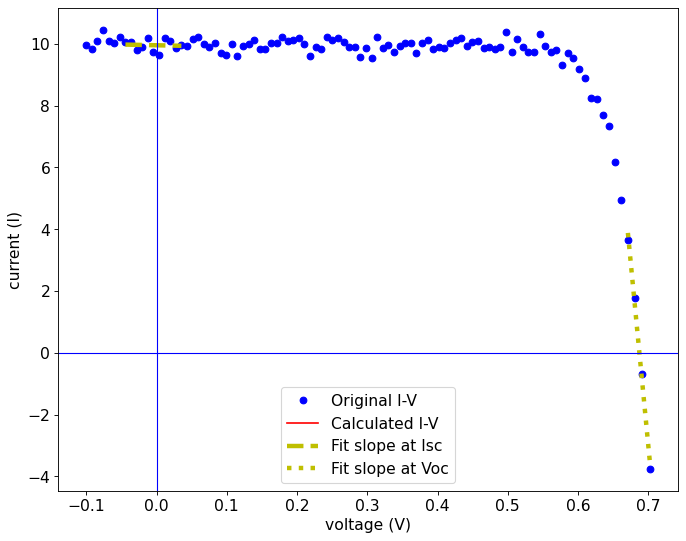

In [15]:
data_size = 100
I_noise = 0.02
IV_curve = model_IV(Isc, I0, n, Rs, Rp, temperature, I_noise, data_size)

IL_extr, I0_extr, n_extr, Rs_extr, Rp_extr, slopeFitIsc, slopeFitVoc = get_IV_params(IV_curve, temperature)

IV_curve_extracted = model_IV(IL_extr, I0_extr, n_extr, Rs_extr, Rp_extr, temperature, 0, 500)

# Print the results and errors
print("Rp = " + f"{Rp_extr:.3f}")
#print("Error Rp = " + f"{100*(Rp_extr-Rp)/Rp:.3f}" + " %")
print("Rs = " + f"{Rs_extr:.3e}")
#print("Error Rs = " + f"{100*(Rs_extr-Rs)/Rs:.3f}" + " %")
print("I0 = " + f"{I0_extr:.3}") 
#print("Error I0 = " + f"{100*(I0_extr-I0)/I0:.3f}" + " %")
print("n = " + f"{n_extr:.3f}")
#print("Error n = " + f"{100*(n_extr-n)/n:.3f}" + " %")
print("IL = " + f"{IL_extr:.3f}")
#print("Error Isc = " + f"{100*(Isc_extr-Isc)/Isc:.3f}" + " %")

# Plot the I-V curves
plt.figure(figsize=(10, 8),dpi=80)
plt.plot(IV_curve[:,0], IV_curve[:,1], 'bo', label="Original I-V")
plt.plot(IV_curve_extracted[:,0], IV_curve_extracted[:,1], color='r', label = "Calculated I-V")
plt.plot(slopeFitIsc[:,0],slopeFitIsc[:,1], '--', linewidth=4, color='y', label = "Fit slope at Isc")
plt.plot(slopeFitVoc[:,0],slopeFitVoc[:,1], ':', linewidth=4, color='y', label = "Fit slope at Voc")
#plt.ylim((-0.01, Isc*1.1))
plt. axvline(x=0,linewidth=1, color='b')
plt. axhline(y=0,linewidth=1, color='b')
plt.xlabel('voltage (V)', size=14)
plt.ylabel('current (I)', size=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

When the number of datapoints is too low or there is significant noise in the data, these slopes can be difficult to obtain from an I-V curve, giving poor fitting results. <br>
You can try to improve the algorithm by, for example, changing the number of datapoints where the slopes are evaluated. This is useful if the total number of datapoints can´t be too high because of technical restrictions (for example if the I-V curve measurement can´t last too long) <br>
You can also take a larger range of voltages around V=0 to fit the I-V curve and calculate the slope. This way the noise can be averaged and its effect reduced.